# Sentiment Analysis

## Cleaning and preprocessing

In [3]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tag import StanfordPOSTagger
import nltk
import os

java_path = "C:/Program Files/Java/jre1.8.0_191/bin/java.exe"   
os.environ['JAVAHOME'] = java_path
st = StanfordPOSTagger('./stanford-postagger-2018-10-16/models/english-bidirectional-distsim.tagger', path_to_jar='./stanford-postagger-2018-10-16/stanford-postagger.jar', java_options='-Xmx2048m')

def preprocess(text, stoplist):
    # To lower-case
    text = text.lower()
    
    # Remove stop words
    text = ' '.join([i for i in text.split() if i not in stoplist])
    
    # Removing punctuation
    text = text.translate(str.maketrans("","", string.punctuation))
    
    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(i) for i in text.split()]
    
    # Pos tagging
    '''tag = st.tag(text)
    text = ['{}_{}'.format(i[0], i[1]) for i in tag]'''
    
    return ' '.join(text)

stoplist = open("stoplist.txt", "r").read().split()
print(preprocess("I believe that this movie was a piece of art. This was one of the best movies I have seen in a while.", stoplist))

believe movie piece art one best movie seen while


## Feature selection

### Building the dataset

In [4]:
import os, sys
import pandas as pd

collection = pd.DataFrame(columns=['doc', 'label'])

stoplist = open("stoplist.txt", "r").read().split()

for file_name in os.listdir('./txt_sentoken/pos'):
    file = open('./txt_sentoken/pos/' + file_name)
    collection = collection.append(pd.DataFrame({'doc':[preprocess(file.read(), stoplist)], 'label':[1]}), ignore_index=True)

    
for file_name in os.listdir('./txt_sentoken/neg'):
    file = open('./txt_sentoken/neg/' + file_name)
    collection = collection.append(pd.DataFrame({'doc':[preprocess(file.read(), stoplist)], 'label':[0]}), ignore_index=True)

print(collection)


                                                    doc label
0     film adapted comic book plenty success whether...     1
1     every now movie come along suspect studio ever...     1
2     got mail work alot better deserves order make ...     1
3     jaw rare film grab attention show single image...     1
4     moviemaking lot like general manager nfl team ...     1
5     june 30 1960 selftaught idealistic yet pragmat...     1
6     apparently director tony kaye major battle new...     1
7     one colleague surprised told willing see betsy...     1
8     bloody clash independence won lumumba refused ...     1
9     american action film slowly drowning death sea...     1
10    watching rat race last week noticed cheek sore...     1
11    noticed something lately never thought pseudo ...     1
12    synopsis bobby garfield yelchin life small tow...     1
13    synopsis movie steven spielberg one today fine...     1
14    police negotiator person entirely unenviable j...     1
15    pl

### tf-idf

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Using sklearn's TfidfVectorizer()
vectorizer = TfidfVectorizer()
result = vectorizer.fit_transform(collection['doc'])

print(result.toarray())

import pandas as pd

tfidf = pd.DataFrame(result.toarray(), index=range(result.shape[0]), columns=vectorizer.get_feature_names())
mean_vector = tfidf.mean().sort_values(ascending=False)
mean = mean_vector.mean()
selected_threshold = 0.0005540915680876647


selected_features = mean_vector[mean_vector > selected_threshold]
print(selected_features)

[[0.06380178 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
film            0.054671
movie           0.040041
one             0.029536
character       0.023156
like            0.021646
just            0.019083
get             0.018427
time            0.018057
scene           0.017939
story           0.017027
good            0.016907
even            0.016769
make            0.016727
will            0.016268
can             0.015404
much            0.014676
life            0.014614
also            0.014371
see             0.014221
two             0.013814
well            0.013564
thing           0.013420
really

We can plot those features

In [ ]:
import matplotlib.pyplot as plt


p = plt.bar(range(len(mean_vector)), mean_vector.values, log=True)
plt.axhline(y=mean_vector.mean(), color='r')
plt.ylabel('Averaged tfidf')
plt.xlabel('Term indices')
plt.title('Tfidf of every terms averaged over all documents')

Now let us train the models

In [11]:
# to 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Building the Vector State Model using frequency vectorizer
vectorizer = CountVectorizer(vocabulary = selected_features.index)
X = vectorizer.fit_transform(collection['doc'])
X = X.toarray()
y = collection['label'].astype(int)  # cast needed as pandas consider cells as 'object'

# Further improve the tests using Xhi²
selectkbest = SelectKBest(chi2, k=1000)  # We keep the 1000 most promising features
X = selectkbest.fit_transform(X, y)

gnb = GaussianNB()
rf = RandomForestClassifier(n_estimators=100)

kf = KFold(n_splits=10, shuffle=True)


'''
Easier solution below

gnb_conf_mat = np.zeros((2,2))
rf_conf_mat = np.zeros((2,2))
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    gnb.fit(X_train, y_train)
    gnb_conf_mat += confusion_matrix(y_test, gnb.predict(X_test))
    
    rf.fit(X_train, y_train)
    rf_conf_mat += confusion_matrix(y_test, rf.predict(X_test))
'''

y_predict_gnb = cross_val_predict(gnb, X, y, cv=kf, n_jobs=-1)
y_predict_rf = cross_val_predict(rf, X, y, cv=kf, n_jobs=-1)

gnb_conf_mat = confusion_matrix(y, y_predict_gnb)
rf_conf_mat = confusion_matrix(y, y_predict_rf)

print(gnb_conf_mat)
print(accuracy_score(y, y_predict_gnb))

print(rf_conf_mat)
print(accuracy_score(y, y_predict_rf))

[[880 120]
 [295 705]]
0.7925
[[852 148]
 [179 821]]
0.8365


Let's evaluate on new reviews

In [9]:
import os, sys
import pandas as pd

new_reviews = pd.DataFrame(columns=['doc', 'label'])

stoplist = open("stoplist.txt", "r").read().split()

for file_name in os.listdir('./new_reviews/pos'):
    file = open('./new_reviews/pos/' + file_name, encoding='utf8')
    new_reviews = new_reviews.append(pd.DataFrame({'doc':[preprocess(file.read(), stoplist)], 'label':[1]}), ignore_index=True)

    
for file_name in os.listdir('./new_reviews/neg'):
    file = open('./new_reviews/neg/' + file_name, encoding='utf8')
    new_reviews = new_reviews.append(pd.DataFrame({'doc':[preprocess(file.read(), stoplist)], 'label':[0]}), ignore_index=True)

print(new_reviews)

                                                  doc label
0   “but time different” say two different charact...     1
1   lushly shot gorgeous location film evokes tone...     1
2   updating u one rockys fearsome opponent sequel...     1
3   guy step ring huge underdog sure he’s got grit...     1
4   sylvester stallone ever tire wonder playing fa...     1
5   three year ago delighted see creed continuatio...     1
6   2015 ryan coogler’s creed came nowhere become ...     1
7   “it’s almost shakespearean” announcer say can’...     1
8   1993 twelveyearold giuseppe di matteo kidnappe...     1
9   divine blend natural supernatural fantasy actu...     1
10  possession hannah grace begin comprehensive as...     0
11  arriving just time win place among year’s wors...     0
12  don’t horror aficionado know corps scary lifel...     0
13  theory putting “possession” title horror movie...     0
14  job working graveyard shift morgue go wrong sh...     0
15  ever watch movie wonder got elusive 

In [13]:
from sklearn.utils import shuffle

# First we have to retrain the models on the whole dataset
X, y = shuffle(X, y, random_state=0)

gnb = GaussianNB()
rf = RandomForestClassifier(n_estimators=100)

rf.fit(X, y.values)
gnb.fit(X, y.values)

X_news = vectorizer.transform(new_reviews['doc'])
X_news = X_news.toarray()
X_news = selectkbest.transform(X_news)
y_news = new_reviews['label'].astype(int)

news_predict_gnb = gnb.predict(X_news)
news_predict_rf = rf.predict(X_news)

# Confusion matrices
print(accuracy_score(y_news, news_predict_gnb))
print(confusion_matrix(y_news, news_predict_gnb))
print(accuracy_score(y_news, news_predict_rf))
print(confusion_matrix(y_news, news_predict_rf))

0.85
[[9 1]
 [2 8]]
0.9
[[10  0]
 [ 2  8]]


We can also compute the optimal threshold (of tfidf values) by looking at the TPR - FPR curve

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

def tpr_fpr(estimator, collection, tfidf_mean, threshold):
    selected_features = tfidf_mean[tfidf_mean > threshold]
    vectorizer = CountVectorizer(vocabulary = selected_features.index)
    X = vectorizer.fit_transform(collection['doc'])
    X = X.toarray()
    y = collection['label'].astype(int)  # cast needed as pandas consider cells as 'object'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_test)

    conf_mat = confusion_matrix(y_test, y_predict)
    
    tn, fp, fn, tp = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]

    return tp/(tp+fn), fp/(fp+tn)

In [17]:
min_threshold = mean_vector.min()
max_threshold = mean_vector.max()

thresholds = np.arange(min_threshold, max_threshold, (max_threshold-min_threshold)/100)
TPRs, FPRs = [], []

rf = RandomForestClassifier(n_estimators=100)
for threshold in thresholds:
    tpr, fpr = tpr_fpr(rf, collection, mean_vector, threshold)
    TPRs.append(tpr)
    FPRs.append(fpr)
print(TPRs)
print(FPRs)

[0.785, 0.87, 0.85, 0.835, 0.815, 0.77, 0.79, 0.78, 0.745, 0.75, 0.715, 0.68, 0.72, 0.71, 0.72, 0.72, 0.71, 0.71, 0.715, 0.705, 0.66, 0.68, 0.685, 0.67, 0.615, 0.61, 0.645, 0.61, 0.57, 0.585, 0.58, 0.56, 0.575, 0.59, 0.575, 0.565, 0.56, 0.555, 0.57, 0.57, 0.535, 0.515, 0.55, 0.56, 0.51, 0.54, 0.53, 0.53, 0.55, 0.535, 0.54, 0.525, 0.505, 0.53, 0.485, 0.51, 0.54, 0.565, 0.575, 0.54, 0.53, 0.565, 0.575, 0.55, 0.58, 0.57, 0.53, 0.54, 0.505, 0.575, 0.565, 0.57, 0.525, 0.53, 0.52, 0.615, 0.55, 0.55, 0.615, 0.455, 0.615, 0.52, 0.615, 0.455, 0.52, 0.455, 0.61, 0.455, 0.52, 0.52, 0.455, 0.455, 0.615, 0.455, 0.55, 0.455, 0.455, 0.455, 0.55, 0.45]
[0.185, 0.22, 0.165, 0.21, 0.23, 0.225, 0.275, 0.27, 0.275, 0.285, 0.26, 0.27, 0.275, 0.29, 0.335, 0.265, 0.295, 0.29, 0.315, 0.34, 0.32, 0.38, 0.38, 0.355, 0.36, 0.35, 0.335, 0.43, 0.45, 0.465, 0.455, 0.425, 0.44, 0.4, 0.46, 0.42, 0.43, 0.4, 0.415, 0.425, 0.5, 0.5, 0.485, 0.545, 0.495, 0.545, 0.525, 0.55, 0.53, 0.515, 0.505, 0.52, 0.505, 0.525, 0.52, 0

Selected threshold = 0.0011007262433489306


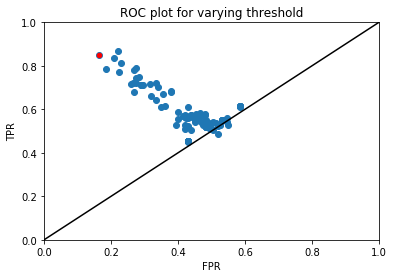

In [18]:
import matplotlib.pyplot as plt
import numpy as np

TPRs_np = np.array(TPRs)
FPRs_np = np.array(FPRs)


selected_threshold_idx = np.argmin(np.sqrt((TPRs_np-1)**2 + (FPRs_np-0)**2))
selected_threshold = thresholds[selected_threshold_idx]

plt.title('ROC plot for varying threshold')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(FPRs, TPRs)
plt.scatter(FPRs[selected_threshold_idx], TPRs[selected_threshold_idx], s=20, c='r')
plt.plot([0,1], [0,1], 'black')

print("Selected threshold =", selected_threshold)

Custom implementation of tfidf

In [19]:
import pandas as pd


def tf(term, document):
    return document.split().count(term)

import numpy as np

def idf(term, corpus):
    return np.log(len(corpus['doc'])/len(corpus[corpus['doc'].str.contains(term)]))

tf('tree', preprocess("this is a tree, and a big tree, not a three", stoplist))

def tf_idf(corpus):
    print("start")
    words = set()
    for doc in corpus['doc']:
        for word in doc.split():
            words.add(word)
    
    tf_idfs = pd.DataFrame(index=range(corpus.shape[0]-1), columns=words)
    
    idfs = {}
    for word in words:
        idfs[word] = idf(word, corpus)
    
    print('started tf_idf')
    
    for doc_idx in range(corpus.shape[0]):
        doc = corpus.iloc[doc_idx]['doc']
        for word in words:
            tf_idfs.at[doc_idx, word] = tf(word, doc) * idfs[word]
    print('finished')
            
    return tf_idfs